In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from datasets import load_dataset
from repopacker import RepoPacker

import warnings
warnings.filterwarnings("ignore")

In [2]:
dataset = load_dataset('bigcode/stackv2_repo_context_sample', split='train')

In [3]:
def reorder_files(sample):
    sample['files'] = RepoPacker(sample['files']).order_files()
    return sample

In [4]:
dataset = dataset.map(lambda x: dict(files= [dict(**file, matching_score=0.) for file in x['files']]))

### Usage is simple:

In [9]:
ord_dataset = dataset.map(reorder_files, num_proc=64)

Map (num_proc=64):   0%|          | 0/1002 [00:00<?, ? examples/s]

### Let's take a look on resulting ordering

In [10]:
python_dataset = ord_dataset.filter(lambda x: any(file['language']=='Python' for file in x['files']) and len(x['files'])>10)

In [18]:
repo = python_dataset[4]['files']
[file['path'] for file in repo]

['/.gitignore',
 '/README.md',
 '/file_manager/core/config_manager/models.py',
 '/file_manager/core/config_manager/config_rw.py',
 '/file_manager/core/__init__.py',
 '/file_manager/core/config_manager/fs_operations.py',
 '/file_manager/core/database.py',
 '/file_manager/core/models.py',
 '/file_manager/core/db_operations.py',
 '/file_manager/core/api.py',
 '/file_manager/gui_app/gui.py',
 '/run.py',
 '/appconf.ini',
 '/file_manager/gui_app/helpers.py']

## Draw graph of connections (imports)

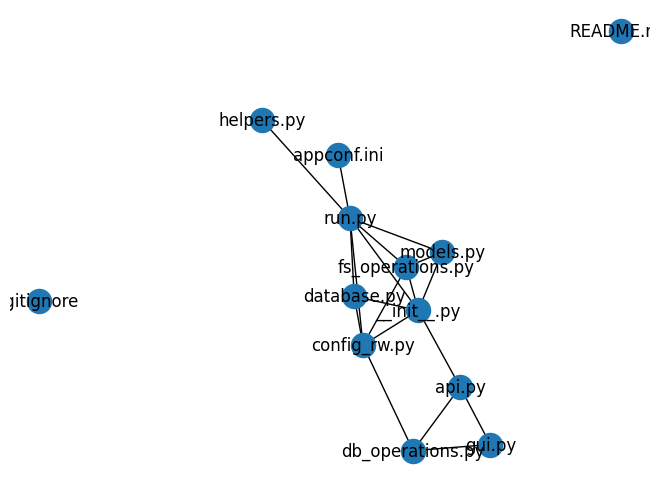

In [56]:
import networkx as nx
packer = RepoPacker(repo)
_ = packer.order_files()

graph = nx.from_scipy_sparse_array(packer._connections_graph, nx.DiGraph)
graph = nx.relabel_nodes(graph, {i:file['path'].split('/')[-1] for i,file in enumerate(repo)})
pos=nx.spring_layout(graph)
nx.draw(graph, pos)
_ =nx.draw_networkx_labels(graph, pos)

In [27]:
# Check insides of ordered files

idx = 2

print(repo[idx]['path'],'\n', repo[idx]['content'][:1_000],'\n-----------------------------------\n')
print(repo[idx+1]['path'], '\n', repo[idx+1]['content'][:1_000])

/file_manager/core/config_manager/models.py 
 

class Config():
    def __init__(self, name, date, ver, path, id=None, attributes=None, special=None):
        self.id = id
        self.name = name
        self.date = date
        self.ver = ver
        self.path = path
        self.attributes = attributes
        self.special = special

    def __repr__(self):
        return f'Config:\n\tid={self.id}\n\tname={self.name}\n\tdate={self.date}\n\tver={self.ver}\n\tpath={self.path}\n\t{self.attributes}'
 
-----------------------------------

/file_manager/core/config_manager/config_rw.py 
 import os
import datetime
import configparser
from .models import Config
from file_manager.core import app_config


def parse_config(rel_path):
    config = configparser.ConfigParser()
    p = os.path.join(app_config.ROOT_PATH, rel_path, app_config.CONFIG_NAME)
    config.read(p, encoding='utf-8')
    id = config.getint('General', 'id', fallback=None)
    name = config.get('General', 'name', fallback=None

### Class `Config` specified in `models.py` and used in `config_rw.py`

In [29]:
idx = 4

print(repo[idx]['path'],'\n', repo[idx]['content'][:1_000],'\n-----------------------------------\n')
print(repo[idx+1]['path'], '\n', repo[idx+1]['content'][:1_000])

/file_manager/core/__init__.py 
 import configparser
import os

APP_CONFIG = 'appconf.ini'

class AppConfig():
    def __init__(self):
        self.APP_PATH = os.path.normpath(os.path.dirname(__file__)).rsplit(os.sep, 2)[0]
        # parse config
        p = os.path.join(self.APP_PATH, APP_CONFIG)
        config = configparser.ConfigParser()
        config.read(p, encoding='utf-8')
        #s = config.get('Settings', 'root')
        self.ROOT_PATH = config.get('Settings', 'root', fallback=os.getcwd())
        self.COPY_PATH = config.get('Settings', 'copy_path', fallback=os.environ['HOMEPATH'])
        self.DATE_FORMAT = config.get('Settings', 'date_format', fallback='%Y-%m-%d') 
        self.CONFIG_NAME = config.get('Settings', 'date_format', fallback='!conf.ini')
        db_name = config.get('Settings', 'database', fallback='db.db')
        self.DB_FP = os.path.join(self.APP_PATH, db_name)
        self.DB_URI = 'sqlite:///' + self.DB_FP

        #get predefined tags
        self.prede

### Variable `app_config` specified in `core/__init__.py` and used in `fs_operations.py`

## Listings for other languages:

In [31]:
# Java
[file['path'] for file in ord_dataset[210]['files']][:30]

['/src/main/java/com/plumre/dataobject/UserPasswordDO.java',
 '/src/main/java/com/plumre/dao/UserPasswordDOMapper.java',
 '/src/main/java/com/plumre/dao/UserDOMapper.java',
 '/src/main/java/com/plumre/dataobject/UserDO.java',
 '/src/main/java/com/plumre/service/model/UserModel.java',
 '/src/main/java/com/plumre/controller/viewobject/UserVO.java',
 '/src/main/resources/mapper/UserPasswordDOMapper.xml',
 '/src/main/resources/mapper/UserDOMapper.xml',
 '/src/main/resources/mapper/OrderDOMapper.xml',
 '/src/main/resources/mapper/PromoDOMapper.xml',
 '/src/main/resources/mapper/SequenceDOMapper.xml',
 '/src/main/resources/mapper/ItemDOMapper.xml',
 '/src/main/resources/mapper/ItemStockDOMapper.xml',
 '/src/main/java/com/plumre/dataobject/SequenceDO.java',
 '/src/main/java/com/plumre/dao/SequenceDOMapper.java',
 '/src/main/java/com/plumre/dao/OrderDOMapper.java',
 '/src/main/java/com/plumre/dataobject/OrderDO.java',
 '/src/main/java/com/plumre/dataobject/ItemDO.java',
 '/src/main/java/com/pl

In [32]:
# JavaScript
[file['path'] for file in ord_dataset[110]['files']][:30]

['/src/Elements/GridListTile.js',
 '/src/Elements/GridList.js',
 '/src/Elements/Grid.js',
 '/src/internal/useMediaQueryTheme.js',
 '/src/Elements/CardMedia.js',
 '/src/internal/TouchRipple.js',
 '/src/Elements/ButtonBase.js',
 '/src/Elements/SelectInput.js',
 '/src/Elements/MenuList.js',
 '/src/Elements/Menu.js',
 '/src/Elements/Popover.js',
 '/src/Elements/Dialog.js',
 '/src/Elements/Backdrop.js',
 '/src/Elements/Badge.js',
 '/src/Elements/NotchedOutline.js',
 '/src/Elements/Avatar.js',
 '/src/Elements/ListItemIcon.js',
 '/src/Elements/ListItemSecondaryAction.js',
 '/src/Elements/ListItem.js',
 '/src/Elements/CardActionArea.js',
 '/src/theme/mergeClasses.js',
 '/src/internal/utils.js',
 '/src/Elements/StepContent.js',
 '/src/Elements/StepLabel.js',
 '/src/Elements/TableSortLabel.js',
 '/src/svg-icons/ArrowDownward.js',
 '/src/svg-icons/ArrowDropDown.js',
 '/src/internal/HiddenJs.js',
 '/src/Elements/Hidden.js',
 '/src/internal/withWidth.js']

# Latency profiling

In [3]:
import itertools
import functools
import time
from tqdm.notebook import tqdm
from multiprocessing import Pool

df = pd.DataFrame(itertools.chain(*dataset['files']))

In [5]:
source_code_files = df[df['language'].isin(['Python','Java','C++','C','C#','JavaScript','PHP','Ruby','Rust'])]

len(source_code_files)

9869

In [10]:
def benchmark(n_files, replace=True):
    files = source_code_files.sample(n_files, replace=replace).to_dict(orient='records')
    
    start = time.time()
    RepoPacker(files).order_files(max_repo_size=n_files+1)
    end = time.time()
    return end-start

In [13]:
n_files = [100, 200, 500, 1_000, 2_000, 5_000, 10_000]
results = {}

for n in n_files:
    with Pool(64) as pool:
        results[n] = list(tqdm(pool.imap(benchmark, [n,]*64), total=64, desc=f'Benchmarking for repo size = {n}'))

Benchmarking for repo size = 100:   0%|          | 0/64 [00:00<?, ?it/s]

Benchmarking for repo size = 200:   0%|          | 0/64 [00:00<?, ?it/s]

Benchmarking for repo size = 500:   0%|          | 0/64 [00:00<?, ?it/s]

Benchmarking for repo size = 1000:   0%|          | 0/64 [00:00<?, ?it/s]

Benchmarking for repo size = 2000:   0%|          | 0/64 [00:00<?, ?it/s]

Benchmarking for repo size = 5000:   0%|          | 0/64 [00:00<?, ?it/s]

Benchmarking for repo size = 10000:   0%|          | 0/64 [00:00<?, ?it/s]

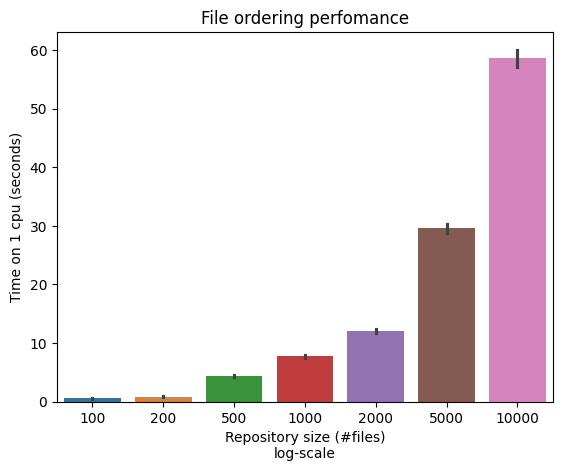

In [28]:
ax = sns.barplot(results)
ax.set_xlabel('Repository size (#files)\nlog-scale')
ax.set_ylabel('Time on 1 cpu (seconds)')
_ = ax.set_title('File ordering perfomance')

#### Note: here is a almost linear dependency between repo size and computing time
#### It becames slow for > 10_000 files in one repository